In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from tqdm import tqdm
import os, sys
import json
import ast
from adjustText import adjust_text

In [2]:
path = "C:/Users/derwi/OneDrive/Documentos/japon/"

In [3]:
table_events = pd.read_parquet(path+'table_events_J1_2024.parquet.gzip')

In [ ]:
## PRIMERO CREAMOS UNA "table_minutes"

In [11]:
## Primero identifico todos los jugadores que jugaron en cada partido
table_minutes = table_events[['match_id','player.id','player.name','team.id','team.name']].drop_duplicates()
table_minutes = table_minutes[table_minutes['player.id'].isna()==False].reset_index(drop=True)

In [12]:
table_minutes

,match_id,player.id,player.name,team.id,team.name
0,3925601,37122.0,Yuki Soma,4609,FC Machida Zelvia
1,3925601,5682.0,Gen Shōji,4609,FC Machida Zelvia
2,3925601,426519.0,Henry Heroki Mochizuki,4609,FC Machida Zelvia
3,3925601,30011.0,Koki Anzai,1881,Kashima Antlers
4,3925601,38278.0,Ikuma Sekigawa,1881,Kashima Antlers
...,...,...,...,...,...
11646,3925226,44356.0,Ayumu Ohata,1882,Urawa Reds
11647,3925226,37242.0,Shinzo Koroki,1882,Urawa Reds
11648,3925226,97654.0,Taishi Matsumoto,1889,Sanfrecce Hiroshima
11649,3925226,11193.0,Shoya Nakajima,1882,Urawa Reds


In [14]:
## Luego necesitamos saber cuánto tiempo en total se jugó en cada partido
minutes_match = table_events[table_events['type.name']=='Half End'][['match_id','period','minute','second']].reset_index(drop=True)
minutes_match = minutes_match.drop_duplicates().reset_index(drop=True)
minutes_match

,match_id,period,minute,second
0,3925601,1,50,22
1,3925601,2,96,28
2,3925597,1,48,9
3,3925597,2,97,12
4,3925603,1,51,17
...,...,...,...,...
747,3925229,2,98,0
748,3925227,1,46,8
749,3925227,2,94,9
750,3925226,1,50,20


In [15]:
## Primer tiempo
minutes_match_1 = minutes_match[minutes_match['period']==1].reset_index(drop=True)
minutes_match_1['time_1T'] = minutes_match_1['minute'] + (minutes_match_1['second']/60)
minutes_match_1 = minutes_match_1.drop(columns={'minute','second','period'})
minutes_match_1

,match_id,time_1T
0,3925601,50.366667
1,3925597,48.150000
2,3925603,51.283333
3,3925598,47.766667
4,3925600,47.733333
...,...,...
371,3925235,46.500000
372,3925231,46.066667
373,3925229,47.150000
374,3925227,46.133333


In [17]:
## Segundo tiempo
minutes_match_2 = minutes_match[minutes_match['period']==2].reset_index(drop=True)
minutes_match_2['time_2T'] = minutes_match_2['minute'] + (minutes_match_2['second']/60) - 45
minutes_match_2 = minutes_match_2.drop(columns={'minute','second','period'})
minutes_match_2

,match_id,time_2T
0,3925601,51.466667
1,3925597,52.200000
2,3925603,51.133333
3,3925598,52.100000
4,3925600,49.716667
...,...,...
371,3925235,52.150000
372,3925231,52.983333
373,3925229,53.000000
374,3925227,49.150000


In [19]:
## Ahora voy a encontrar las sustituciones
substitutions = table_events[table_events['type.name']=='Substitution'].reset_index(drop=True)
substitutions_in = substitutions[['match_id','period','minute','second','team.id','substitution.replacement.id']].copy()
substitutions_in['time_in'] = np.where(substitutions_in['period']==2,substitutions_in['minute'] + (substitutions_in['second']/60)-45,substitutions_in['minute'] + (substitutions_in['second']/60))
substitutions_in = substitutions_in.rename(columns={'substitution.replacement.id':'player.id',
                                                   'period':'period_in'})
substitutions_in = substitutions_in.drop(columns=['minute','second'])
substitutions_in

,match_id,period_in,team.id,player.id,time_in
0,3925601,1,1881,42233.0,14.766667
1,3925601,2,4609,24853.0,0.016667
2,3925601,2,4609,46707.0,0.016667
3,3925601,2,4609,42141.0,18.250000
4,3925601,2,4609,33492.0,28.100000
...,...,...,...,...,...
3388,3925226,2,1882,37242.0,30.700000
3389,3925226,2,1882,44356.0,30.900000
3390,3925226,2,1889,97654.0,36.516667
3391,3925226,2,1882,11193.0,36.883333


In [20]:
substitutions_out = substitutions[['match_id','period','minute','second','team.id','player.id']].copy()
substitutions_out['time_out'] = np.where(substitutions_out['period']==2,substitutions_out['minute'] + (substitutions_out['second']/60)-45,substitutions_out['minute'] + (substitutions_out['second']/60))
substitutions_out = substitutions_out.rename(columns={'period':'period_out'})
substitutions_out = substitutions_out.drop(columns=['minute','second'])
substitutions_out

,match_id,period_out,team.id,player.id,time_out
0,3925601,1,1881,38262.0,14.766667
1,3925601,2,4609,42221.0,0.016667
2,3925601,2,4609,25402.0,0.016667
3,3925601,2,4609,426519.0,18.250000
4,3925601,2,4609,41144.0,28.100000
...,...,...,...,...,...
3388,3925226,2,1882,11220.0,30.700000
3389,3925226,2,1882,95367.0,30.900000
3390,3925226,2,1889,97650.0,36.516667
3391,3925226,2,1882,37806.0,36.883333


In [21]:
## Luego uno todo
table_minutes = pd.merge(table_minutes,minutes_match_1,on='match_id',how='left')
table_minutes = pd.merge(table_minutes,minutes_match_2,on='match_id',how='left')
table_minutes = pd.merge(table_minutes,substitutions_in,on=['match_id','team.id','player.id'],how='left')
table_minutes = pd.merge(table_minutes,substitutions_out,on=['match_id','team.id','player.id'],how='left')
table_minutes

,match_id,player.id,player.name,team.id,team.name,time_1T,time_2T,period_in,time_in,period_out,time_out
0,3925601,37122.0,Yuki Soma,4609,FC Machida Zelvia,50.366667,51.466667,NaN,NaN,NaN,NaN
1,3925601,5682.0,Gen Shōji,4609,FC Machida Zelvia,50.366667,51.466667,NaN,NaN,NaN,NaN
2,3925601,426519.0,Henry Heroki Mochizuki,4609,FC Machida Zelvia,50.366667,51.466667,NaN,NaN,2.0,18.25
3,3925601,30011.0,Koki Anzai,1881,Kashima Antlers,50.366667,51.466667,NaN,NaN,NaN,NaN
4,3925601,38278.0,Ikuma Sekigawa,1881,Kashima Antlers,50.366667,51.466667,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11646,3925226,44356.0,Ayumu Ohata,1882,Urawa Reds,50.333333,52.666667,2.0,30.900000,NaN,NaN
11647,3925226,37242.0,Shinzo Koroki,1882,Urawa Reds,50.333333,52.666667,2.0,30.700000,NaN,NaN
11648,3925226,97654.0,Taishi Matsumoto,1889,Sanfrecce Hiroshima,50.333333,52.666667,2.0,36.516667,NaN,NaN
11649,3925226,11193.0,Shoya Nakajima,1882,Urawa Reds,50.333333,52.666667,2.0,36.883333,NaN,NaN


In [22]:
## Finalmente, calculamos los minutos jugados
table_minutes['Minutes played'] = np.where((table_minutes['period_in'].isna()) & (table_minutes['period_out'].isna()),table_minutes['time_1T']+table_minutes['time_2T'],
                                               np.where((table_minutes['period_in'].isna()) & (table_minutes['period_out']==1),table_minutes['time_out'],
                                                        np.where((table_minutes['period_in'].isna()) & (table_minutes['period_out']==2),table_minutes['time_1T']+table_minutes['time_out'],
                                                                 np.where((table_minutes['period_in']==1) & (table_minutes['period_out'].isna()),table_minutes['time_1T']-table_minutes['time_in']+table_minutes['time_2T'],
                                                                          np.where((table_minutes['period_in']==2) & (table_minutes['period_out'].isna()),table_minutes['time_2T']-table_minutes['time_in'],
                                                                                   np.where((table_minutes['period_in']==1) & (table_minutes['period_out']==1),table_minutes['time_out']-table_minutes['time_in'],
                                                                                            np.where((table_minutes['period_in']==2) & (table_minutes['period_out']==2),table_minutes['time_out']-table_minutes['time_in'],
                                                                                                     np.where((table_minutes['period_in']==1) & (table_minutes['period_out']==2),table_minutes['time_1T']-table_minutes['time_in']+table_minutes['time_out'],0))))))))
table_minutes

,match_id,player.id,player.name,team.id,team.name,time_1T,time_2T,period_in,time_in,period_out,time_out,Minutes played
0,3925601,37122.0,Yuki Soma,4609,FC Machida Zelvia,50.366667,51.466667,NaN,NaN,NaN,NaN,101.833333
1,3925601,5682.0,Gen Shōji,4609,FC Machida Zelvia,50.366667,51.466667,NaN,NaN,NaN,NaN,101.833333
2,3925601,426519.0,Henry Heroki Mochizuki,4609,FC Machida Zelvia,50.366667,51.466667,NaN,NaN,2.0,18.25,68.616667
3,3925601,30011.0,Koki Anzai,1881,Kashima Antlers,50.366667,51.466667,NaN,NaN,NaN,NaN,101.833333
4,3925601,38278.0,Ikuma Sekigawa,1881,Kashima Antlers,50.366667,51.466667,NaN,NaN,NaN,NaN,101.833333
...,...,...,...,...,...,...,...,...,...,...,...,...
11646,3925226,44356.0,Ayumu Ohata,1882,Urawa Reds,50.333333,52.666667,2.0,30.900000,NaN,NaN,21.766667
11647,3925226,37242.0,Shinzo Koroki,1882,Urawa Reds,50.333333,52.666667,2.0,30.700000,NaN,NaN,21.966667
11648,3925226,97654.0,Taishi Matsumoto,1889,Sanfrecce Hiroshima,50.333333,52.666667,2.0,36.516667,NaN,NaN,16.150000
11649,3925226,11193.0,Shoya Nakajima,1882,Urawa Reds,50.333333,52.666667,2.0,36.883333,NaN,NaN,15.783333


In [ ]:
Ahora sí, vamos a calcular nuestra tabla de métricas para la temporada:

In [23]:
## Antes de ello hacemos lo siguiente:

## Algo que solemos hacer es agrupar las Posiciones
table_events['group_position'] = np.where(table_events['position.name'].isin(['Right Center Back','Center Back','Left Center Back']),'Central Defender',
                                                 np.where(table_events['position.name'].isin(['Left Back','Left Wing Back','Right Back','Right Wing Back']),'Full Back',
                                                                 np.where(table_events['position.name'].isin(['Right Defensive Midfield','Left Defensive Midfield','Center Defensive Midfield',
                                                                                                              'Center Midfield','Right Center Midfield','Left Center Midfield']),'Center Midfielder',
                                                                                 np.where(table_events['position.name'].isin(['Center Attacking Midfield','Right Attacking Midfield','Left Attacking Midfield']),'Attacking Midfielder',
                                                                                         np.where(table_events['position.name'].isin(['Right Wing','Left Wing','Left Midfield','Right Midfield']),'Wide player',
                                                                                                 np.where(table_events['position.name'].isin(['Center Forward','Left Center Forward','Right Center Forward']),'Forward',
                                                                                                         np.where(table_events['position.name'].isin(['Goalkeeper']),'Goalkeeper',None
                                                                                                                 )))))))


## Para poder agrupar bien, necesitamos eliminar filas que no contenga info de jugadores
events_player = table_events[table_events['type.name'].isin(['Starting XI','Half Start','Half End','Player Off',
                                                                       'Injury Stoppage','Substitution','Tactical Shift',
                                                                      'Player On','Bad Behaviour'])==False].reset_index(drop=True)


In [51]:
## Definimos las columnas y métricas que queremos tener en nuestra tabla
df = events_player.copy()

metricas_sp = pd.DataFrame({
    'match_id' : df['match_id'],
    'player.id' : df['player.id'],
    'player.name' : df['player.name'],
    'team.id' : df['team.id'],
    'team.name' : df['team.name'],
    'group_position':df['group_position'],
    'Shot' : df['type.name']=='Shot',
    'XG' : df['shot.statsbomb_xg'],
    'Shot_Goal' : df['shot.outcome.name']=='Goal',
    'Shot in Last Third' : (df['type.name']=='Shot')&(df['x']>=80)
})


In [52]:
## Posición más usada por partido
posicion_sp = metricas_sp.groupby(['match_id','player.id','team.id']).agg({
    'group_position': lambda x: x.value_counts().index[0]
}).reset_index()

In [47]:
posicion_sp

,match_id,player.id,team.id,group_position
0,3925226,3530.0,1882,Full Back
1,3925226,11193.0,1882,Center Midfielder
2,3925226,11220.0,1882,Forward
3,3925226,16296.0,1889,Forward
4,3925226,23222.0,1882,Center Midfielder
...,...,...,...,...
11644,3925603,232843.0,1885,Forward
11645,3925603,385707.0,1889,Full Back
11646,3925603,400801.0,1889,Center Midfielder
11647,3925603,406397.0,1885,Wide player


In [53]:
## Métricas agrgadas por partido
metricas_sp = metricas_sp.drop(columns='group_position').groupby(['match_id','player.id','player.name','team.id','team.name']).sum().reset_index()


In [54]:
metricas_sp

,match_id,player.id,player.name,team.id,team.name,Shot,XG,Shot_Goal,Shot in Last Third
0,3925226,3530.0,Hiroki Sakai,1882,Urawa Reds,1,0.0844,0,1
1,3925226,11193.0,Shoya Nakajima,1882,Urawa Reds,1,0.0238,0,1
2,3925226,11220.0,Thiago Santos Santana,1882,Urawa Reds,1,0.0366,0,1
3,3925226,16296.0,Pieros Soteriou,1889,Sanfrecce Hiroshima,5,1.1326,0,5
4,3925226,23222.0,Samuel Gustafson,1882,Urawa Reds,1,0.1572,0,1
...,...,...,...,...,...,...,...,...,...
11644,3925603,232843.0,Isa Sakamoto,1885,Gamba Osaka,2,0.8319,2,2
11645,3925603,385707.0,Sota Koshimichi,1889,Sanfrecce Hiroshima,0,0.0000,0,0
11646,3925603,400801.0,Yotaro Nakajima,1889,Sanfrecce Hiroshima,0,0.0000,0,0
11647,3925603,406397.0,Welton Felipe Paragua de Melo,1885,Gamba Osaka,2,0.1379,0,2


In [55]:
## Uno las dos tablas
metricas_sp = pd.merge(metricas_sp,posicion_sp,on=['match_id','player.id','team.id'],how='left')

In [56]:
metricas_sp

,match_id,player.id,player.name,team.id,team.name,Shot,XG,Shot_Goal,Shot in Last Third,group_position
0,3925226,3530.0,Hiroki Sakai,1882,Urawa Reds,1,0.0844,0,1,Full Back
1,3925226,11193.0,Shoya Nakajima,1882,Urawa Reds,1,0.0238,0,1,Center Midfielder
2,3925226,11220.0,Thiago Santos Santana,1882,Urawa Reds,1,0.0366,0,1,Forward
3,3925226,16296.0,Pieros Soteriou,1889,Sanfrecce Hiroshima,5,1.1326,0,5,Forward
4,3925226,23222.0,Samuel Gustafson,1882,Urawa Reds,1,0.1572,0,1,Center Midfielder
...,...,...,...,...,...,...,...,...,...,...
11644,3925603,232843.0,Isa Sakamoto,1885,Gamba Osaka,2,0.8319,2,2,Forward
11645,3925603,385707.0,Sota Koshimichi,1889,Sanfrecce Hiroshima,0,0.0000,0,0,Full Back
11646,3925603,400801.0,Yotaro Nakajima,1889,Sanfrecce Hiroshima,0,0.0000,0,0,Center Midfielder
11647,3925603,406397.0,Welton Felipe Paragua de Melo,1885,Gamba Osaka,2,0.1379,0,2,Wide player


In [57]:
## Y ahora traigo los minutos jugados a la tabla
metricas_sp = pd.merge(metricas_sp,table_minutes[['match_id','player.id','player.name','team.id','Minutes played']],on=['match_id','player.id','player.name','team.id'],how='left')


In [58]:
metricas_sp #hasta aca tenemso las metricas de Shot in last third por partido. 

,match_id,player.id,player.name,team.id,team.name,Shot,XG,Shot_Goal,Shot in Last Third,group_position,Minutes played
0,3925226,3530.0,Hiroki Sakai,1882,Urawa Reds,1,0.0844,0,1,Full Back,103.000000
1,3925226,11193.0,Shoya Nakajima,1882,Urawa Reds,1,0.0238,0,1,Center Midfielder,15.783333
2,3925226,11220.0,Thiago Santos Santana,1882,Urawa Reds,1,0.0366,0,1,Forward,81.033333
3,3925226,16296.0,Pieros Soteriou,1889,Sanfrecce Hiroshima,5,1.1326,0,5,Forward,77.900000
4,3925226,23222.0,Samuel Gustafson,1882,Urawa Reds,1,0.1572,0,1,Center Midfielder,103.000000
...,...,...,...,...,...,...,...,...,...,...,...
11644,3925603,232843.0,Isa Sakamoto,1885,Gamba Osaka,2,0.8319,2,2,Forward,95.733333
11645,3925603,385707.0,Sota Koshimichi,1889,Sanfrecce Hiroshima,0,0.0000,0,0,Full Back,7.000000
11646,3925603,400801.0,Yotaro Nakajima,1889,Sanfrecce Hiroshima,0,0.0000,0,0,Center Midfielder,36.183333
11647,3925603,406397.0,Welton Felipe Paragua de Melo,1885,Gamba Osaka,2,0.1379,0,2,Wide player,85.233333


In [59]:
## number of matches
n_matches = metricas_sp.groupby(['player.id','player.name','team.id','team.name','group_position'])['match_id'].nunique().reset_index().rename(columns={'match_id':'Matches'})


In [60]:
n_matches

,player.id,player.name,team.id,team.name,group_position,Matches
0,3175.0,Eiji Kawashima,4652,Júbilo Iwata,Goalkeeper,31
1,3530.0,Hiroki Sakai,1882,Urawa Reds,Full Back,10
2,3743.0,Amadou Bakayoko,1897,Consadole Sapporo,Attacking Midfielder,1
3,3743.0,Amadou Bakayoko,1897,Consadole Sapporo,Forward,5
4,5679.0,Yūya Ōsako,1886,Vissel Kobe,Forward,35
...,...,...,...,...,...,...
1154,436263.0,Ryuma Nakano,4631,Kyoto Sanga FC,Center Midfielder,4
1155,436263.0,Ryuma Nakano,4631,Kyoto Sanga FC,Wide player,1
1156,436493.0,Taisei Inoue,1894,Sagan Tosu,Full Back,1
1157,439942.0,Daichi Suzuki,1894,Sagan Tosu,Forward,2


In [64]:
## sum of metrics
metricas_shot = metricas_sp.drop(columns='match_id').groupby(['player.id','player.name','team.id','team.name','group_position']).sum().reset_index()

## join tables
metricas_shot = pd.merge(metricas_shot,n_matches,on=['player.id','player.name','team.id','team.name','group_position'],how='left')


In [65]:
metricas_shot

,player.id,player.name,team.id,team.name,group_position,Shot,XG,Shot_Goal,Shot in Last Third,Minutes played,Matches
0,3175.0,Eiji Kawashima,4652,Júbilo Iwata,Goalkeeper,1,0.0558,0,1,3122.216667,31
1,3530.0,Hiroki Sakai,1882,Urawa Reds,Full Back,4,0.3237,1,4,636.916667,10
2,3743.0,Amadou Bakayoko,1897,Consadole Sapporo,Attacking Midfielder,0,0.0000,0,0,34.583333,1
3,3743.0,Amadou Bakayoko,1897,Consadole Sapporo,Forward,3,1.1239,1,3,105.133333,5
4,5679.0,Yūya Ōsako,1886,Vissel Kobe,Forward,89,13.0739,11,89,3213.750000,35
...,...,...,...,...,...,...,...,...,...,...,...
1154,436263.0,Ryuma Nakano,4631,Kyoto Sanga FC,Center Midfielder,4,0.1931,0,4,84.116667,4
1155,436263.0,Ryuma Nakano,4631,Kyoto Sanga FC,Wide player,0,0.0000,0,0,8.466667,1
1156,436493.0,Taisei Inoue,1894,Sagan Tosu,Full Back,0,0.0000,0,0,24.833333,1
1157,439942.0,Daichi Suzuki,1894,Sagan Tosu,Forward,3,0.4857,1,3,139.350000,2


In [66]:
metricas_shot['Matches'].describe()

count    1159.000000
mean       10.050906
std        10.476637
min         1.000000
25%         2.000000
50%         5.000000
75%        15.500000
max        38.000000
Name: Matches, dtype: float64

In [84]:
metricas_shot['Shot'].describe()

count    1159.000000
mean        8.578085
std        14.137454
min         0.000000
25%         0.000000
50%         3.000000
75%        10.500000
max       122.000000
Name: Shot, dtype: float64

In [86]:
shot_1200_15 =  metricas_shot[
    (metricas_shot['Minutes played'] > 1200) &
    (metricas_shot['Matches'] > 15) & (metricas_shot['Shot'] > 50)] 

shot_1200_15 = shot_1200_15.dropna(subset=['Shot'])

shot_1200_15 = shot_1200_15.sort_values(by='Shot in Last Third', ascending=False)
shot_1200_15

,player.id,player.name,team.id,team.name,group_position,Shot,XG,Shot_Goal,Shot in Last Third,Minutes played,Matches
266,37649.0,Anderson José Lopes de Souza,1880,Yokohama F. Marinos,Forward,122,23.0836,24,121,3539.483333,37
803,115073.0,Leonardo de Sousa Pereira,1891,Cerezo Osaka,Forward,117,22.4625,21,114,3518.300000,38
16,6337.0,Yoshinori Muto,1886,Vissel Kobe,Wide player,99,12.2100,12,99,3335.800000,36
4,5679.0,Yūya Ōsako,1886,Vissel Kobe,Forward,89,13.0739,11,89,3213.750000,35
81,25310.0,Matheus Gonçalves Sávio,1890,Kashiwa Reysol,Wide player,88,5.7422,8,87,3134.666667,32
15,6191.0,Takashi Usami,1885,Gamba Osaka,Forward,82,7.3999,11,82,2484.516667,30
545,76410.0,Marcelo Ryan Silvestre dos Santos,1894,Sagan Tosu,Forward,82,10.0811,12,81,2334.983333,29
34,11220.0,Thiago Santos Santana,1882,Urawa Reds,Forward,82,11.1416,12,80,2353.766667,36
517,45933.0,Mao Hosoya,1890,Kashiwa Reysol,Forward,80,8.6821,6,80,2685.316667,31
534,49586.0,Yan Matheus Santos Souza,1880,Yokohama F. Marinos,Wide player,79,5.4064,5,79,2613.533333,35


In [ ]:
## JUGADORES CON MÁS DE 1200 MINUTOS, MÁS DE 15 JUEGOS Y MÁS DE 50 SHOT. 

## Agregamos un P90, goal/shot y Goal-XG

In [98]:
shot_1200_15['Goal_P90'] = (shot_1200_15['Shot_Goal'] / metricas_shot['Minutes played']) * 90
shot_1200_15['Goal/Shot'] = (shot_1200_15['Shot_Goal'] / metricas_shot['Shot'])
shot_1200_15['G-XG'] = (shot_1200_15['Shot_Goal'] - metricas_shot['XG'])

shot_1200_15 = shot_1200_15.sort_values(by='G-XG', ascending=False)
shot_1200_15

## JUGADORES QUE RINDEN POR ENCIMA DE LO ESPERADO.

,player.id,player.name,team.id,team.name,group_position,Shot,XG,Shot_Goal,Shot in Last Third,Minutes played,Matches,Goal_P90,Goal/Shot,G-XG
142,37133.0,Ryo Germain,4652,Júbilo Iwata,Forward,71,11.2255,18,71,2794.750000,28,0.579658,0.253521,6.7745
985,377952.0,Shin Yamada,1892,Kawasaki Frontale,Forward,72,14.2828,18,72,1903.533333,33,0.851049,0.250000,3.7172
15,6191.0,Takashi Usami,1885,Gamba Osaka,Forward,82,7.3999,11,82,2484.516667,30,0.398468,0.134146,3.6001
516,45876.0,Shahab Zahedi,4260,Avispa Fukuoka,Forward,72,5.5195,9,70,1591.466667,30,0.508964,0.125000,3.4805
97,31111.0,Yuma Suzuki,1881,Kashima Antlers,Forward,56,9.8519,13,56,2913.600000,31,0.401565,0.232143,3.1481
81,25310.0,Matheus Gonçalves Sávio,1890,Kashiwa Reysol,Wide player,88,5.7422,8,87,3134.666667,32,0.229689,0.090909,2.2578
545,76410.0,Marcelo Ryan Silvestre dos Santos,1894,Sagan Tosu,Forward,82,10.0811,12,81,2334.983333,29,0.462530,0.146341,1.9189
41,16296.0,Pieros Soteriou,1889,Sanfrecce Hiroshima,Forward,60,7.3761,9,59,1281.750000,24,0.631949,0.150000,1.6239
381,41144.0,Se-Hun Oh,4609,FC Machida Zelvia,Forward,58,6.5186,8,58,2396.716667,33,0.300411,0.137931,1.4814
954,231939.0,Erison Danilo de Souza,1892,Kawasaki Frontale,Forward,60,5.9258,7,60,1258.733333,23,0.500503,0.116667,1.0742


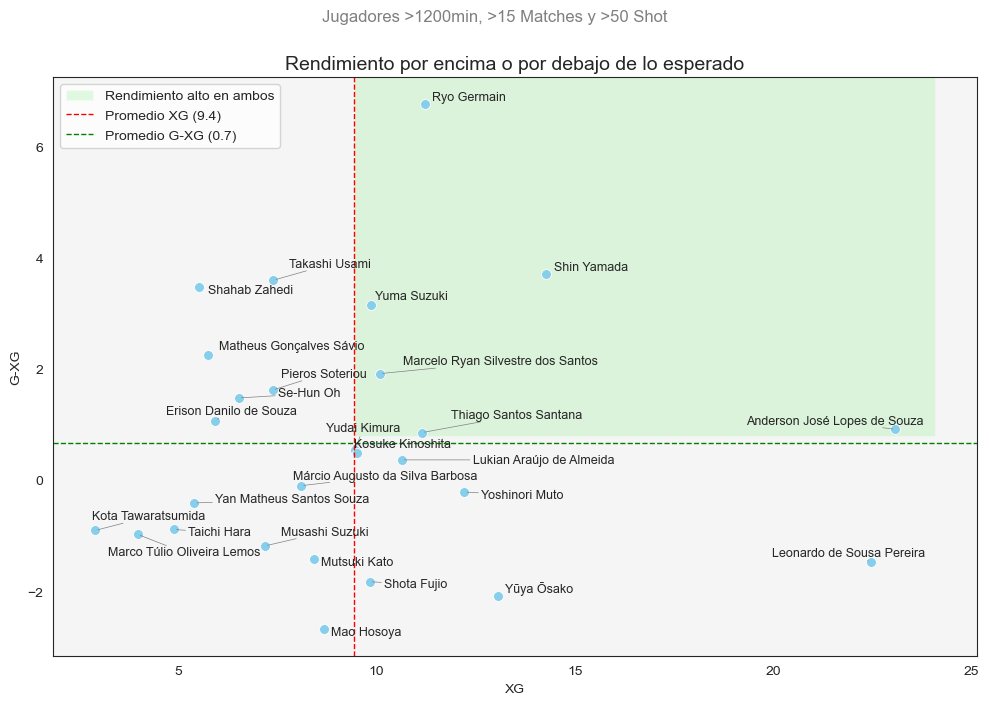

In [132]:
# Calcular promedios
avg_XG = shot_1200_15["XG"].mean()
avg_G_XG = shot_1200_15["G-XG"].mean()

# Calcular promedios
avg_XG = shot_1200_15["XG"].mean()
avg_G_XG = shot_1200_15["G-XG"].mean()

plt.figure(figsize=(10,7))
sns.set_style("white")
sns.scatterplot(data=shot_1200_15, x="XG", y="G-XG", s=50, color='skyblue')

ax = plt.gca()

ax = plt.gca()
ax.set_facecolor('whitesmoke')  # color dentro del gráfico

# Crear lista de textos para ajustar
texts = []
for i, row in shot_1200_15.iterrows():
    texts.append(ax.text(row["XG"], row["G-XG"], row["player.name"], fontsize=9))

# Ajustar posiciones para evitar superposición
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Cuadrante superior derecho
x_min, x_max = shot_1200_15["XG"].min()-1, shot_1200_15["XG"].max()+1
y_min, y_max = shot_1200_15["G-XG"].min()-1, shot_1200_15["G-XG"].max()+1
ax.axvspan(avg_XG, x_max, ymin=(avg_G_XG - y_min)/(y_max - y_min), ymax=1,
           facecolor="lightgreen", alpha=0.25, zorder=0, label="Rendimiento alto en ambos")

# Líneas promedio
plt.axvline(x=avg_XG, color="red", linestyle="--", linewidth=1, label=f"Promedio XG ({avg_XG:.1f})")
plt.axhline(y=avg_G_XG, color="green", linestyle="--", linewidth=1, label=f"Promedio G-XG ({avg_G_XG:.1f})")

plt.title("Rendimiento por encima o por debajo de lo esperado", fontsize=14)
plt.suptitle("Jugadores >1200min, >15 Matches y >50 Shot", fontsize=12, y=1.0009, color='gray')
plt.xlabel("XG")
plt.ylabel("G-XG")
plt.legend()
plt.tight_layout()
plt.show()